In [161]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.backends.cudnn as cudnn
import numpy as np
import torchvision
from torchvision import datasets, models, transforms
import matplotlib.pyplot as plt
import time
import os
from PIL import Image
from tempfile import TemporaryDirectory
from sklearn.model_selection import train_test_split
import mlflow

In [187]:
# hyperparameters
# NUM_EPOCHS = 25
# TODO: update to 50 in final experiments
NUM_EPOCHS = 12 # new, converged in this time
# TODO: update to 64 once larger dataset is available
BATCH_SIZE = 4
LAYERS_TRAINED = 2
LEARNING_RATE = 0.001
MOMENTUM = 0.9

# use balanced torch imagefolder dataset
experiment = 'MPI'
target_num_of_classes = 3

# add seconds to run training to mlflow!
runtime = 0

In [180]:
data_transforms = {
    'train': transforms.Compose([
        transforms.Grayscale(3),
        transforms.GaussianBlur(3),
        transforms.ColorJitter(brightness=[0.95,1.05], contrast=[0.8,1.2]),
        transforms.RandomAffine(degrees=[-5,5], shear=(1,10,1,10), fill=255),
        transforms.RandomResizedCrop(224, scale=(0.9, 1.0)),
        transforms.ToTensor(),
        transforms.Normalize([0.5, 0.5, 0.5], [0.2, 0.2, 0.2])
    ]),
    'test': transforms.Compose([
        transforms.Grayscale(3),
        transforms.Resize((224,224)),
        transforms.ToTensor(),
        transforms.Normalize([0.5, 0.5, 0.5], [0.2, 0.2, 0.2])
    ]),
}


data_dir = f'/home/riikoro/fossil_data/tooth_samples/torch_imagefolder_2/{experiment}'
image_datasets = {x: datasets.ImageFolder(os.path.join(data_dir, x),
                                          data_transforms[x])
                  for x in ['train', 'test']}
dataloaders = {x: torch.utils.data.DataLoader(image_datasets[x], batch_size=4,
                                             shuffle=True, num_workers=0)
              for x in ['train', 'test']}
dataset_sizes = {x: len(image_datasets[x]) for x in ['train', 'test']}
class_names = image_datasets['train'].classes

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
class_names

['I', 'M', 'P']

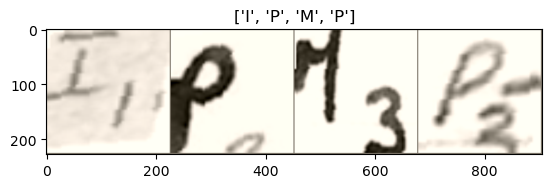

In [181]:
def imshow(inp, title=None):
    """Display image for Tensor."""
    inp = inp.numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    plt.imshow(inp)
    if title is not None:
        plt.title(title)
    plt.pause(0.001)  # pause a bit so that plots are updated

# Get a batch of training data
inputs, classes = next(iter(dataloaders['train']))

# Make a grid from batch
out = torchvision.utils.make_grid(inputs)

imshow(out, title=[class_names[x] for x in classes])

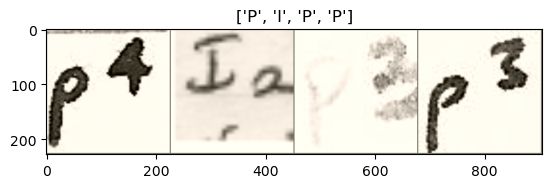

In [182]:
# Get a batch of test data
inputs, classes = next(iter(dataloaders['test']))

# Make a grid from batch
out = torchvision.utils.make_grid(inputs)

imshow(out, title=[class_names[x] for x in classes])

In [190]:
# model = torchvision.models.vit_b_16(weights='DEFAULT')
# model = torchvision.models.alexnet(weights='DEFAULT')
model = torchvision.models.efficientnet_v2_s(weights='EfficientNet_V2_S_Weights.IMAGENET1K_V1')
for param in list(model.parameters())[:-1*(LAYERS_TRAINED+1)]:
    param.requires_grad = False

# Parameters of newly constructed modules have requires_grad=True by default
# alexnet
# num_ftrs = model.classifier[6].in_features
# model.classifier[6] = nn.Linear(num_ftrs, target_num_of_classes)

# vit
# num_ftrs = model.heads[0].in_features
# model.heads[0] = nn.Linear(num_ftrs, target_num_of_classes)

# efficientnet
num_ftrs = model.classifier[1].in_features
model.classifier[1] = nn.Linear(num_ftrs, target_num_of_classes)

model = model.to(device)
criterion = nn.CrossEntropyLoss()


# vit 
# optimizer = optim.SGD(model.heads[0].parameters(), lr=0.001, momentum=0.9)
# alexnet
# optimizer = optim.SGD(model.classifier[6].parameters(), lr=LEARNING_RATE, momentum=MOMENTUM)
# efficientnet
optimizer = optim.SGD(model.classifier[1].parameters(), lr=LEARNING_RATE, momentum=MOMENTUM)

# Decay LR by a factor of 0.1 every 7 epochs
exp_lr_scheduler = lr_scheduler.StepLR(optimizer, step_size=7, gamma=0.1)

for param in model.parameters():
    print(param.requires_grad)
model

False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
Fals

EfficientNet(
  (features): Sequential(
    (0): Conv2dNormActivation(
      (0): Conv2d(3, 24, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
      (1): BatchNorm2d(24, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
      (2): SiLU(inplace=True)
    )
    (1): Sequential(
      (0): FusedMBConv(
        (block): Sequential(
          (0): Conv2dNormActivation(
            (0): Conv2d(24, 24, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
            (1): BatchNorm2d(24, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
            (2): SiLU(inplace=True)
          )
        )
        (stochastic_depth): StochasticDepth(p=0.0, mode=row)
      )
      (1): FusedMBConv(
        (block): Sequential(
          (0): Conv2dNormActivation(
            (0): Conv2d(24, 24, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
            (1): BatchNorm2d(24, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
  

In [191]:
def train_model(model, criterion, optimizer, scheduler, num_epochs=25):
    best_train_acc = 0.0
    best_test_acc = 0.0

    for epoch in range(num_epochs):
        print(f'Epoch {epoch}/{num_epochs - 1}')
        print('-' * 10)

        # Each epoch has a training and validation phase
        for phase in ['train', 'test']:
            if phase == 'train':
                model.train()  # Set model to training mode
            else:
                model.eval()   # Set model to evaluate mode

            running_loss = 0.0
            running_corrects = 0

            # Iterate over data.
            for inputs, labels in dataloaders[phase]:
                inputs = inputs.to(device)
                labels = labels.to(device)

                # zero the parameter gradients
                optimizer.zero_grad()

                # forward
                # track history if only in train
                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    _, preds = torch.max(outputs, 1)
                    loss = criterion(outputs, labels)

                    # backward + optimize only if in training phase
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                # statistics
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)

            if phase == 'train':
                scheduler.step()
            epoch_loss = running_loss / dataset_sizes[phase]
            epoch_acc = running_corrects.double() / dataset_sizes[phase]

            print(f'{phase} Loss: {epoch_loss:.4f} Acc: {epoch_acc:.4f}')
            
            if phase == 'test':
                best_test_acc = epoch_acc.item()
            if phase == 'train':
                best_train_acc = epoch_acc.item()

        print()

    print(f'Best val Acc: {best_test_acc:4f}')

    return model, best_train_acc, best_test_acc

In [192]:
def visualize_model(model, num_images=6):
    was_training = model.training
    model.eval()
    images_so_far = 0
    fig = plt.figure()

    with torch.no_grad():
        for i, (inputs, labels) in enumerate(dataloaders['test']):
            inputs = inputs.to(device)
            labels = labels.to(device)

            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)

            for j in range(inputs.size()[0]):
                images_so_far += 1
                ax = plt.subplot(num_images//2, 2, images_so_far)
                ax.axis('off')
                ax.set_title(f'predicted: {class_names[preds[j]]}')
                imshow(inputs.cpu().data[j])

                if images_so_far == num_images:
                    model.train(mode=was_training)
                    return
        model.train(mode=was_training)

In [193]:
model, train_acc, test_acc = train_model(model, criterion, optimizer, exp_lr_scheduler, num_epochs=NUM_EPOCHS)

Epoch 0/11
----------
train Loss: 0.9757 Acc: 0.5521
test Loss: 0.9095 Acc: 0.6481

Epoch 1/11
----------
train Loss: 0.8268 Acc: 0.6562
test Loss: 0.7821 Acc: 0.7593

Epoch 2/11
----------
train Loss: 0.7760 Acc: 0.6708
test Loss: 0.7814 Acc: 0.7037

Epoch 3/11
----------
train Loss: 0.6963 Acc: 0.7229
test Loss: 0.6916 Acc: 0.7593

Epoch 4/11
----------
train Loss: 0.6719 Acc: 0.7292
test Loss: 0.7152 Acc: 0.7407

Epoch 5/11
----------
train Loss: 0.6514 Acc: 0.7354
test Loss: 0.6440 Acc: 0.7963

Epoch 6/11
----------
train Loss: 0.6198 Acc: 0.7667
test Loss: 0.7081 Acc: 0.7407

Epoch 7/11
----------
train Loss: 0.6780 Acc: 0.7208
test Loss: 0.6181 Acc: 0.7963

Epoch 8/11
----------
train Loss: 0.6248 Acc: 0.7333
test Loss: 0.6498 Acc: 0.7778

Epoch 9/11
----------
train Loss: 0.6218 Acc: 0.7083
test Loss: 0.7031 Acc: 0.7037

Epoch 10/11
----------
train Loss: 0.6167 Acc: 0.7562
test Loss: 0.6192 Acc: 0.7963

Epoch 11/11
----------
train Loss: 0.6437 Acc: 0.7458
test Loss: 0.6982 Acc

In [194]:
print(test_acc)

0.7222222222222222


In [195]:
print(train_acc)

0.7458333333333333


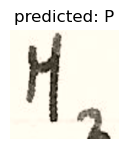

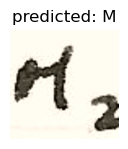

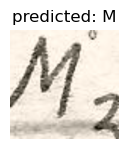

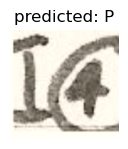

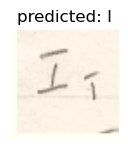

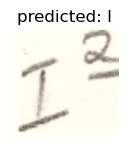

In [196]:
visualize_model(model)

plt.ioff()
plt.show()

In [177]:
model_pt_filename = f'{experiment}.pt'
torch.save(model, model_pt_filename)

In [178]:
%env MLFLOW_TRACKING_URI=sqlite:///../../mlflow.db
mlflow.set_experiment(experiment)

params = {
    'data_v': [3,4,5],
    'train_size': dataset_sizes['train'],
    'test_size': dataset_sizes['test'],
    'batch_size': BATCH_SIZE,
    'num_epochs': NUM_EPOCHS,
    'base_model_path': type(model),
    'layers_trained': LAYERS_TRAINED,
    'learning_rate': LEARNING_RATE,
    'momentum': MOMENTUM
}

# Start an MLflow run
with mlflow.start_run():
    # Log the hyperparameters
    mlflow.log_params(params)

    # Log the loss metric
    mlflow.log_metric("most frequent class occurence fraction", fraction)
    mlflow.log_metric("training accuracy", train_acc)
    mlflow.log_metric("test accuracy", test_acc)

    mlflow.log_artifact(model_pt_filename)

    # Set a tag that we can use to remind ourselves what this run was for
    mlflow.set_tag("info", "EfficientNet")

env: MLFLOW_TRACKING_URI=sqlite:///../../mlflow.db
